In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/ResearchWork_2023/cropped_images_zip/cropped_training_images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cropped_training_images/2446_left.jpg  
  inflating: cropped_training_images/2446_right.jpg  
  inflating: cropped_training_images/2447_left.jpg  
  inflating: cropped_training_images/2447_right.jpg  
  inflating: cropped_training_images/2448_left.jpg  
  inflating: cropped_training_images/2448_right.jpg  
  inflating: cropped_training_images/2449_left.jpg  
  inflating: cropped_training_images/2449_right.jpg  
  inflating: cropped_training_images/244_left.jpg  
  inflating: cropped_training_images/244_right.jpg  
  inflating: cropped_training_images/2450_left.jpg  
  inflating: cropped_training_images/2450_right.jpg  
  inflating: cropped_training_images/2451_left.jpg  
  inflating: cropped_training_images/2451_right.jpg  
  inflating: cropped_training_images/2452_left.jpg  
  inflating: cropped_training_images/2452_right.jpg  
  inflating: cropped_training_images/2453_left.jpg  
  inflating: cropped_training_images/2453_

In [4]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
accuracy = tf.keras.metrics.Accuracy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1_score = tfa.metrics.F1Score(num_classes=8
                               )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00


In [5]:
# Load the image data and one-hot encoded multi-label data
# Load the data from the excel sheet into a pandas dataframe
# Load both left and right eye dataset
base_path = '/content/drive/MyDrive/ResearchWork_2023'
left_df = pd.read_excel(f'{base_path}/updated_left_eye.xlsx')
right_df = pd.read_excel(f'{base_path}/updated_right_eye.xlsx')

#concating both dataframes
df = pd.concat([left_df, right_df], axis=0)


# Split the data into two arrays, one for the image paths and one for the labels
images_base_path = '/content/cropped_training_images/'
image_paths = images_base_path + df["Fundus"].values
labels = df.iloc[:, 3:].values

# Convert the lists to tensors
image_paths = tf.constant(image_paths)
labels = tf.constant(labels)

# Create a dataset from the image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

In [6]:
# Load the images and preprocess them
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [250, 250])
    image = tf.keras.applications.inception_resnet_v2.preprocess_input(image)
    return image, label

# Apply the load_and_preprocess_image function to the dataset
dataset = dataset.map(load_and_preprocess_image)

# Shuffle the data and batch it
batch_size = 64
dataset = dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

In [7]:
def split_data(dataset, train_split, test_split, val_split):
    # Calculate the size of each split
    dataset_size = dataset.reduce(tf.constant(0, dtype=tf.int64), lambda acc, _: acc + 1).numpy()
    train_size = int(dataset_size * train_split)
    val_size = int(dataset_size * val_split)
    test_size = int(dataset_size * test_split)

    # Shuffle the elements of the dataset randomly
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset into train, validation, and test sets
    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)
    return train_dataset, test_dataset, val_dataset

In [8]:
# Split the data into training and validation sets
train_dataset, test_dataset, val_dataset = split_data(dataset, train_split=0.7, test_split=0.15, val_split=0.15)

In [9]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v4.h5')

In [10]:
base_learning_rate = 0.00001
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
               loss='binary_crossentropy',
              metrics=['accuracy', precision , recall, f1_score])

In [11]:
new_history=new_model.fit(train_dataset, epochs=25, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/25
76/76 [==============================] - 55s 310ms/step - loss: 0.0356 - accuracy: 0.9561 - precision: 0.9950 - recall: 0.9904 - f1_score: 0.9644 - val_loss: 0.0354 - val_accuracy: 0.9458 - val_precision: 0.9906 - val_recall: 0.9897 - val_f1_score: 0.9614
Epoch 2/25
76/76 [==============================] - 32s 256ms/step - loss: 0.0345 - accuracy: 0.9580 - precision: 0.9950 - recall: 0.9913 - f1_score: 0.9671 - val_loss: 0.0348 - val_accuracy: 0.9550 - val_precision: 0.9966 - val_recall: 0.9940 - val_f1_score: 0.9636
Epoch 3/25
76/76 [==============================] - 32s 257ms/step - loss: 0.0344 - accuracy: 0.9548 - precision: 0.9962 - recall: 0.9931 - f1_score: 0.9627 - val_loss: 0.0313 - val_accuracy: 0.9657 - val_precision: 1.0000 - val_recall: 0.9974 - val_f1_score: 0.9789
Epoch 4/25
76/76 [==============================] - 31s 255ms/step - loss: 0.0344 - accuracy: 0.9582 - precision: 0.9961 - recall: 0.9921 - f1_score: 0.9662 - val_loss: 0.0346 - val_accuracy: 0.9556 

In [13]:
new_model.save('/content/drive/MyDrive/ResearchWork_2023/models/model_2_v7.h5')

In [14]:
import matplotlib.pyplot as plt

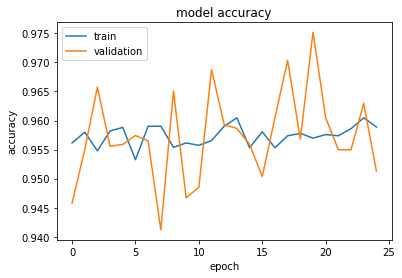

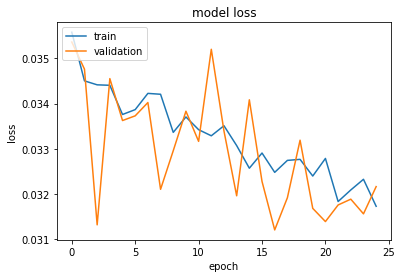

In [15]:
plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()